In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\TrialRasterTest.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

# full_page_figure_illustrator_size_pxls = np.array([521, 655])
# full_page_paper_illustrator_size_pxls = np.array([620, 801])
full_page_figure_illustrator_size_pxls = np.array([521, 660])
full_page_paper_illustrator_size_pxls = np.array([612, 792])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls


SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\TrialRasterTest_2023-12-06.py


In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl_colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 10.15 s


In [5]:
# create customized colormap

truncate_pink = truncate_colormap(plt.get_cmap("pink"), 0.2, 1)
truncate_gray = truncate_colormap(plt.get_cmap("gray"), 0.2, 1)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 10.16 s


In [6]:
# create trial raster plot function
def create_trial_raster_plot(
    fig,
    gs,
    src_hdf5_file_path,
):
    plt.subplot(gs)
    plot_ax = plt.gca()
    with h5py.File(trial_raster_plot_hdf5_file_path, "r") as hdf5_file:
        plot_spike_events = hdf5_file["plot_spike_events"][()]
        plot_subthd_dFFs = hdf5_file["plot_subthd_dFFs"][()]
        plot_x_ticks = hdf5_file["plot_x_ticks"][()]
        plot_x_labels = hdf5_file["plot_x_labels"][()]

        plot_y_ticks = np.arange(0, plot_spike_events.shape[0], 100)
        # plot_y_labels = [f"{num:.0f}" for num in plot_y_ticks]
        
        plt_xs = np.arange(plot_spike_events.shape[1])
        event_xs = []
        for i_trail in range(plot_spike_events.shape[0]):
            event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])
    
        plt.imshow(plot_subthd_dFFs,
                   aspect = "auto",
                   interpolation = "none",
                   cmap = plot_cmap,
                   vmin = plot_vmin,
                   vmax = plot_vmax,
                   alpha = 1,
                  )
        cbar = plt.colorbar(ax = plot_ax, 
                            location = "right",
                            pad=0.01, 
                            aspect = 25,
                            ticks=[plot_vmin, 0, plot_vmax]
                           )
        cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
        cbar.ax.tick_params(labelsize=plot_font_size, 
                            rotation = 0, 
                            pad = 1) 
        cbar.set_label(
                       # label = "dF/F (%)", 
                       label = "$\mathrm{\Delta}$F/F (%)",
                       # loc = "bottom",
                       fontsize = plot_font_size, fontname = "Arial", labelpad = -8)
        plt.eventplot(event_xs, color = plot_spike_color,
                  lineoffsets = 1,
                  linelengths = 1,
                  linewidths = 0.5)
        plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
        plt.xlabel("Time (s)", 
                   fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        # plt.xlim(left = plot_x_ticks[0],
        #          right = plot_x_ticks[-1])
        plt.xlim(left = 0,
                 right = plot_spike_events.shape[-1])
        # plt.yticks(ticks = plot_y_ticks, labels = plot_y_labels)
        plt.ylim(bottom = 0,
                 top = plot_spike_events.shape[0])
        plt.ylabel("Cell #", 
                   fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)
        
        plot_ax.tick_params(axis='both', which='major', 
                                labelsize=plot_font_size, pad = 1)
        plot_ax.tick_params(axis='both', which='minor', 
                                labelsize=plot_font_size)


def create_trial_raster_plot_ver01(
    fig,
    input_gs,
    src_hdf5_file_path,
):
    # plt.subplot(input_gs)
    cur_subplot_gs =  mpl_gridspec.GridSpecFromSubplotSpec(2, 2,  
                                                           width_ratios = np.array([10, 1]),
                                                           height_ratios = np.ones((2,)),
                                                           wspace = 0,
                                                           hspace = 0,
                                                           subplot_spec=input_gs)
    plot_ax = plt.gca()
    with h5py.File(trial_raster_plot_hdf5_file_path, "r") as hdf5_file:
        plot_spike_events = hdf5_file["plot_spike_events"][()]
        plot_subthd_dFFs = hdf5_file["plot_subthd_dFFs"][()]
        plot_x_ticks = hdf5_file["plot_x_ticks"][()]
        plot_x_labels = hdf5_file["plot_x_labels"][()]

        plot_y_ticks = np.arange(0, plot_spike_events.shape[0], 100)
        # plot_y_labels = [f"{num:.0f}" for num in plot_y_ticks]
        
        plt_xs = np.arange(plot_spike_events.shape[1])
        event_xs = []
        for i_trail in range(plot_spike_events.shape[0]):
            event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

        plot_ax = plt.subplot(cur_subplot_gs[0,0])
        subthd_im = plot_ax.imshow(plot_subthd_dFFs,
                                   aspect = "auto",
                                   interpolation = "none",
                                   cmap = plot_cmap,
                                   vmin = plot_vmin,
                                   vmax = plot_vmax,
                                   alpha = 1,
                                  )
        
        plot_ax =  plt.subplot(cur_subplot_gs[0,1])
        # plot_ax.axes.get_yaxis().set_ticks([])
        # plot_ax.axes.get_xaxis().set_ticks([])
        # plot_ax.spines['top'].set_visible(False)
        # plot_ax.spines['right'].set_visible(False)
        # plot_ax.spines['bottom'].set_visible(False)
        # plot_ax.spines['left'].set_visible(False)
        
        # plot_cax = plot_ax.inset_axes([0, 0, 1, 1])
        plot_cax = plot_ax
        cbar = plt.colorbar(subthd_im,
                            cax = plot_cax, 
                            location = "right",
                            # pad=0, 
                            # aspect = 80,
                            ticks=[plot_vmin, 0, plot_vmax]
                           )
        cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
        cbar.ax.tick_params(labelsize=plot_font_size, 
                            rotation = 0, 
                            pad = 1) 
        cbar.set_label(
                       # label = "dF/F (%)", 
                       label = "$\mathrm{\Delta}$F/F (%)",
                       # loc = "bottom",
                       fontsize = plot_font_size, fontname = "Arial", labelpad = -8)
        
        plot_ax = plt.subplot(cur_subplot_gs[1,0])
        plot_ax.eventplot(event_xs, color = plot_spike_color,
                          lineoffsets = 1,
                          linelengths = 1,
                          linewidths = 0.5)
        # plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
        # plt.xlabel("Time (s)", 
        #            fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        # # plt.xlim(left = plot_x_ticks[0],
        # #          right = plot_x_ticks[-1])
        # plt.xlim(left = 0,
        #          right = plot_spike_events.shape[-1])
        # # plt.yticks(ticks = plot_y_ticks, labels = plot_y_labels)
        # plt.ylim(bottom = 0,
        #          top = plot_spike_events.shape[0])
        # plt.ylabel("Cell #", 
        #            fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        # plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)
        
        # plot_ax.tick_params(axis='both', which='major', 
        #                         labelsize=plot_font_size, pad = 1)
        # plot_ax.tick_params(axis='both', which='minor', 
        #                         labelsize=plot_font_size)


def create_trial_raster_plot_ver02(
    fig,
    input_gs,
    src_hdf5_file_path,
):

    main_subplot_width = 0.97
    main_subplot_height = 0.48
    sub_subplot_width = 0.02
    sub_subplot_height = main_subplot_height
    
    plt.subplot(input_gs)
    plot_ax = plt.gca()
    plot_ax.axes.get_yaxis().set_ticks([])
    plot_ax.axes.get_xaxis().set_ticks([])
    plot_ax.spines['top'].set_visible(False)
    plot_ax.spines['right'].set_visible(False)
    plot_ax.spines['bottom'].set_visible(False)
    plot_ax.spines['left'].set_visible(False)
    
    with h5py.File(trial_raster_plot_hdf5_file_path, "r") as hdf5_file:
        plot_spike_events = hdf5_file["plot_spike_events"][()]
        plot_subthd_dFFs = hdf5_file["plot_subthd_dFFs"][()]
        plot_x_ticks = hdf5_file["plot_x_ticks"][()]
        plot_x_labels = hdf5_file["plot_x_labels"][()]

        plot_y_ticks = np.arange(0, plot_spike_events.shape[0], 100)
        # plot_y_labels = [f"{num:.0f}" for num in plot_y_ticks]
        
        plt_xs = np.arange(plot_spike_events.shape[1])
        event_xs = []
        for i_trail in range(plot_spike_events.shape[0]):
            event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

        cur_inset_ax = plot_ax.inset_axes([0, 0, main_subplot_width, main_subplot_height])
        cur_subthd_im = cur_inset_ax.imshow(plot_subthd_dFFs,
                                               aspect = "auto",
                                               interpolation = "none",
                                               cmap = plot_cmap,
                                               vmin = plot_vmin,
                                               vmax = plot_vmax,
                                               alpha = 1,
                                              )
        cur_inset_ax.set_xlim(left = 0,
                              right = plot_subthd_dFFs.shape[-1])
        cur_inset_ax.set_xticks(plot_x_ticks)
        cur_inset_ax.set_xticklabels(plot_x_labels)
        cur_inset_ax.set_xlabel("Time (s)", 
                                fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        cur_inset_ax.set_ylim(bottom = 0,
                              top = plot_spike_events.shape[0])
        cur_inset_ax.set_yticks(plot_y_ticks)
        cur_inset_ax.tick_params(axis='both', which='major', 
                                labelsize=plot_font_size, pad = 1)
        cur_inset_ax.tick_params(axis='both', which='minor', 
                                labelsize=plot_font_size)
        cur_inset_ax.set_ylabel("Cell #", 
                                fontsize = plot_font_size, fontname = "Arial", labelpad = 0)

        
        cur_plot_cax = plot_ax.inset_axes([1 - sub_subplot_width, 0, sub_subplot_width, main_subplot_height])
        cbar = plt.colorbar(cur_subthd_im,
                            cax = cur_plot_cax, 
                            location = "right",
                            ticks=[plot_vmin, 0, plot_vmax]
                           )
        cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
        cbar.ax.tick_params(labelsize=plot_font_size, 
                            rotation = 0, 
                            pad = 1) 
        cbar.set_label(
                       # label = "dF/F (%)", 
                       label = "$\mathrm{\Delta}$F/F (%)",
                       # loc = "bottom",
                       fontsize = plot_font_size, fontname = "Arial", labelpad = -8)
        
        cur_inset_ax = plot_ax.inset_axes([0, 1 - main_subplot_height, main_subplot_width, main_subplot_height])
        cur_inset_ax.eventplot(event_xs, color = plot_spike_color,
                              lineoffsets = 1,
                              linelengths = 1,
                              linewidths = 0.5)
        cur_inset_ax.set_xlim(left = 0,
                             right = plot_spike_events.shape[-1])
        cur_inset_ax.set_xticks([])
        cur_inset_ax.set_ylim(bottom = 0,
                              top = plot_spike_events.shape[0])
        cur_inset_ax.set_yticks(plot_y_ticks)
        # cur_inset_ax.invert_yaxis()
        cur_inset_ax.tick_params(axis='both', which='major', 
                                labelsize=plot_font_size, pad = 1)
        cur_inset_ax.tick_params(axis='both', which='minor', 
                                labelsize=plot_font_size)
       
       
        
        
        # plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
        # plt.xlabel("Time (s)", 
        #            fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        # # plt.xlim(left = plot_x_ticks[0],
        # #          right = plot_x_ticks[-1])
        # plt.xlim(left = 0,
        #          right = plot_spike_events.shape[-1])
        # # plt.yticks(ticks = plot_y_ticks, labels = plot_y_labels)
        # plt.ylim(bottom = 0,
        #          top = plot_spike_events.shape[0])
        # plt.ylabel("Cell #", 
        #            fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
        # plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)
        
        # plot_ax.tick_params(axis='both', which='major', 
        #                         labelsize=plot_font_size, pad = 1)
        # plot_ax.tick_params(axis='both', which='minor', 
        #                         labelsize=plot_font_size)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 10.21 s


In [7]:
# source configuration

trial_raster_plot_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures\trial_raster_plot_trial13.hdf5"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 10.22 s


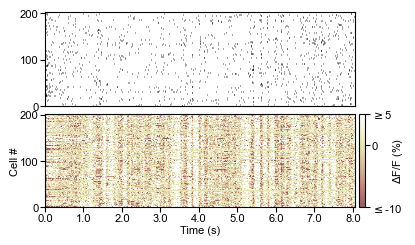

Time since last sync = 11.06 s


In [8]:
plot_cmap = truncate_pink
plot_spike_color = "black"

plot_font_size = 8
plot_panel_font_size = 8

plot_vmin = -0.1
plot_vmax = +0.05

plot_hist_color = r"#d3d3d3"
plot_hist_edge_color = r"black"
plot_scatter_color =  r"#808080"
plot_scatter_size = 10
plot_line_color = r"#a6a6a6"

plot_dg_colors = ["black", "#FF9B50"]

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0]
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1]

fig = plt.figure(
                 figsize = (fig_width,fig_height), 
                 constrained_layout=True,
                # layout = "constrained",
                )

plot_nof_gs_cols = 2
plot_nof_gs_rows = 9
plot_raster_plot_group_row_offset = 3

gs = mpl_gridspec.GridSpec(plot_nof_gs_rows, plot_nof_gs_cols, 
                           width_ratios = np.ones((plot_nof_gs_cols,)),
                           height_ratios = np.ones((plot_nof_gs_rows,)),
                           wspace=0.0, hspace=0.0,
                           figure = fig,
                          )

create_trial_raster_plot_ver02(fig, 
                                 gs[plot_raster_plot_group_row_offset:plot_raster_plot_group_row_offset+2,0:plot_nof_gs_cols//2],
                                 trial_raster_plot_hdf5_file_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)